## 🧩 Block 1 – Imports, Seed, Device

In [16]:
# ===============================================================
# PORTBRAIN – DQN Ship Handling with Dynamic Ship Counts (Clean Version)
# ===============================================================

import random
from collections import deque, namedtuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt

# For nicer plots in Jupyter
%matplotlib inline

# ---------------------------------------------------------------
# Reproducibility & Device
# ---------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


## 🧩 Block 2 – Hyperparameters & Config

In [17]:
# ---------------------------------------------------------------
# Hyperparameters & Config
# ---------------------------------------------------------------
NUM_EPISODES        = 100
MAX_STEPS_PER_EP    = 50

GAMMA               = 0.99
LR                  = 1e-3
BATCH_SIZE          = 64
REPLAY_CAPACITY     = 10_000

EPS_START           = 1.0
EPS_END             = 0.1
EPS_DECAY_EPISODES  = 80  # episode index at which epsilon reaches EPS_END

TARGET_UPDATE_FREQ  = 10

MAX_SHIPS_QUEUE     = 20
MAX_HANDLE_PER_STEP = 3
ARRIVAL_RATE        = 1.0  # Poisson λ

TRAINING_HISTORY_CSV = "portbrain_training_history.csv"

# Print ONLY these episodes as text summaries
EPISODES_TO_PRINT = {1, 5, 10, 20, 25, 40, 50, 75, 90, 100}


## 🧩 Block 3 – Environment

In [18]:
# ---------------------------------------------------------------
# Port Environment
# ---------------------------------------------------------------
class PortEnv:
    """
    Simple port environment:
    - Random initial ships (e.g., 5–12)
    - Poisson ship arrivals each step
    - Agent chooses how many ships to handle (0..MAX_HANDLE_PER_STEP)
    """
    def __init__(self,
                 max_ships_queue=MAX_SHIPS_QUEUE,
                 max_handle_per_step=MAX_HANDLE_PER_STEP,
                 max_steps=MAX_STEPS_PER_EP,
                 arrival_rate=ARRIVAL_RATE):
        
        self.max_ships_queue = max_ships_queue
        self.max_handle_per_step = max_handle_per_step
        self.max_steps = max_steps
        self.arrival_rate = arrival_rate

        self.state_dim = 3
        self.action_dim = max_handle_per_step + 1

        self.reset()

    def reset(self):
        # random initial ships between 5 and 12
        self.ships_waiting = np.random.randint(5, 13)
        self.initial_ships = self.ships_waiting

        self.ships_handled = 0
        self.timestep = 0
        self.done = False

        return self._get_obs()

    def _get_obs(self):
        return np.array(
            [self.ships_waiting, self.ships_handled, self.timestep],
            dtype=np.float32
        )

    def step(self, action: int):
        if self.done:
            raise ValueError("Episode is done. Call reset().")

        self.timestep += 1

        # clamp action
        action = int(max(0, min(action, self.max_handle_per_step)))

        # handle ships
        handled = min(action, self.ships_waiting)
        self.ships_waiting -= handled
        self.ships_handled += handled

        # new arrivals (Poisson)
        new_arrivals = np.random.poisson(self.arrival_rate)
        self.ships_waiting = min(
            self.ships_waiting + new_arrivals,
            self.max_ships_queue
        )

        # reward: encourage handling, penalize waiting
        reward = handled * 2.0
        reward -= 1.0 * self.ships_waiting
        reward -= 0.1  # small time penalty

        # termination
        if (self.ships_waiting == 0 and self.timestep > 0) or \
           (self.timestep >= self.max_steps):
            self.done = True

        info = {
            "ships_waiting": self.ships_waiting,
            "ships_handled": self.ships_handled,
            "timestep": self.timestep,
            "new_arrivals": new_arrivals,
            "handled_this_step": handled,
        }

        return self._get_obs(), reward, self.done, info


## 🧩 Block 4 – Replay Memory

In [19]:
# ---------------------------------------------------------------
# Replay Memory
# ---------------------------------------------------------------
Transition = namedtuple(
    'Transition',
    ('state', 'action', 'reward', 'next_state', 'done')
)

class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## 🧩 Block 5 – DQN Network

In [20]:
# ---------------------------------------------------------------
# DQN Network
# ---------------------------------------------------------------
class DQN(nn.Module):
    def __init__(self, state_dim: int, action_dim: int):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.layers(x)

## 🧩 Block 6 – DQN Agent

In [21]:
# ---------------------------------------------------------------
# DQN Agent
# ---------------------------------------------------------------
class DQNAgent:
    def __init__(self, state_dim: int, action_dim: int):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE

        self.policy_net = DQN(state_dim, action_dim).to(device)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = ReplayMemory(REPLAY_CAPACITY)

    def get_epsilon(self, episode: int) -> float:
        frac = min(1.0, episode / EPS_DECAY_EPISODES)
        return EPS_START + frac * (EPS_END - EPS_START)

    def select_action(self, state: np.ndarray, episode: int) -> int:
        eps = self.get_epsilon(episode)
        if random.random() < eps:
            return random.randrange(self.action_dim)

        state_t = torch.tensor(state, dtype=torch.float32,
                               device=device).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.policy_net(state_t)
        return int(torch.argmax(q_vals, dim=1).item())

    def optimize(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_b = torch.tensor(batch.state, dtype=torch.float32, device=device)
        action_b = torch.tensor(batch.action, dtype=torch.int64,
                                device=device).unsqueeze(1)
        reward_b = torch.tensor(batch.reward, dtype=torch.float32,
                                device=device).unsqueeze(1)
        next_state_b = torch.tensor(batch.next_state, dtype=torch.float32,
                                    device=device)
        done_b = torch.tensor(batch.done, dtype=torch.float32,
                              device=device).unsqueeze(1)

        # Q(s,a)
        q_values = self.policy_net(state_b).gather(1, action_b)

        # max_a' Q_target(s', a')
        with torch.no_grad():
            next_q = self.target_net(next_state_b).max(1, keepdim=True)[0]

        target = reward_b + self.gamma * next_q * (1 - done_b)

        loss = nn.SmoothL1Loss()(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


## 🧩 Block 7 – Episode Summary Printer

In [22]:
# ---------------------------------------------------------------
# Pretty Episode Summary Printer
# ---------------------------------------------------------------
def print_episode_summary(ep: int, metrics: dict):
    print("\n" + "─" * 70)
    print(f"📘 Episode {ep}")
    print(f" • Initial Ships      : {metrics['initial_ships']}")
    print(f" • Total Arrivals     : {metrics['total_arrivals']}")
    print(f" • Total Ships Seen   : {metrics['total_ships_seen']}")
    print(f" • Ships Handled      : {metrics['ships_handled']}")
    print(f" • Ships Remaining    : {metrics['ships_remaining']}")
    print(f" • Reward             : {metrics['total_reward']:.2f}")
    print(f" • Steps              : {metrics['steps']}")
    print(f" • Avg Q-value        : {metrics['avg_q_value']:.2f}")
    print(f" • Epsilon            : {metrics['epsilon']:.3f}")


## 🧩 Block 8 – Initialize Env & Agent

In [23]:
# ---------------------------------------------------------------
# Initialize Environment & Agent
# ---------------------------------------------------------------
env = PortEnv()
agent = DQNAgent(env.state_dim, env.action_dim)

episode_history = []

## 🧩 Block 9 – Training Loop (100 Episodes, Logging All, Printing Some)

In [24]:
# ---------------------------------------------------------------
# Training Loop
# ---------------------------------------------------------------
print("Starting training...")

for ep in trange(NUM_EPISODES, desc="Training"):
    state = env.reset()
    done = False

    total_reward = 0.0
    q_values_list = []
    steps = 0

    eps = agent.get_epsilon(ep)

    initial_ships = env.initial_ships
    total_arrivals = 0
    last_info = None

    while not done and steps < MAX_STEPS_PER_EP:
        steps += 1

        action = agent.select_action(state, ep)

        # Q-value for logging
        with torch.no_grad():
            state_t = torch.tensor(state, dtype=torch.float32,
                                   device=device).unsqueeze(0)
            q_vals = agent.policy_net(state_t)
            q_values_list.append(q_vals.max().item())

        next_state, reward, done, info = env.step(action)
        last_info = info

        total_reward += reward
        total_arrivals += info["new_arrivals"]

        agent.memory.push(state, action, reward, next_state, float(done))
        agent.optimize()

        state = next_state

    # target network update
    if (ep + 1) % TARGET_UPDATE_FREQ == 0:
        agent.update_target()

    avg_q = float(np.mean(q_values_list)) if q_values_list else 0.0
    ships_handled_final = last_info["ships_handled"] if last_info else 0
    ships_remaining_final = last_info["ships_waiting"] if last_info else 0
    total_ships_seen = initial_ships + total_arrivals

    metrics = {
        "episode": ep + 1,
        "total_reward": total_reward,
        "steps": steps,
        "initial_ships": initial_ships,
        "total_arrivals": total_arrivals,
        "total_ships_seen": total_ships_seen,
        "ships_handled": ships_handled_final,
        "ships_remaining": ships_remaining_final,
        "avg_q_value": avg_q,
        "epsilon": eps,
    }

    # Store in history for analysis
    episode_history.append(metrics)

    # Print only selected episodes
    if (ep + 1) in EPISODES_TO_PRINT:
        print_episode_summary(ep + 1, metrics)

print("\nTraining completed!")


Starting training...


Training:   4%|▍         | 4/100 [00:00<00:03, 24.33it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 1
 • Initial Ships      : 8
 • Total Arrivals     : 13
 • Total Ships Seen   : 21
 • Ships Handled      : 21
 • Ships Remaining    : 0
 • Reward             : -118.90
 • Steps              : 19
 • Avg Q-value        : 1.00
 • Epsilon            : 1.000

──────────────────────────────────────────────────────────────────────
📘 Episode 5
 • Initial Ships      : 7
 • Total Arrivals     : 1
 • Total Ships Seen   : 8
 • Ships Handled      : 8
 • Ships Remaining    : 0
 • Reward             : -3.50
 • Steps              : 5
 • Avg Q-value        : 0.81
 • Epsilon            : 0.955


Training:   8%|▊         | 8/100 [00:00<00:03, 29.71it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 10
 • Initial Ships      : 11
 • Total Arrivals     : 21
 • Total Ships Seen   : 32
 • Ships Handled      : 32
 • Ships Remaining    : 0
 • Reward             : -56.50
 • Steps              : 15
 • Avg Q-value        : 3.36
 • Epsilon            : 0.899


Training:  23%|██▎       | 23/100 [00:01<00:04, 16.27it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 20
 • Initial Ships      : 10
 • Total Arrivals     : 22
 • Total Ships Seen   : 32
 • Ships Handled      : 32
 • Ships Remaining    : 0
 • Reward             : -111.20
 • Steps              : 22
 • Avg Q-value        : 3.23
 • Epsilon            : 0.786


Training:  27%|██▋       | 27/100 [00:01<00:05, 14.10it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 25
 • Initial Ships      : 11
 • Total Arrivals     : 19
 • Total Ships Seen   : 30
 • Ships Handled      : 30
 • Ships Remaining    : 0
 • Reward             : -19.00
 • Steps              : 20
 • Avg Q-value        : 4.50
 • Epsilon            : 0.730


Training:  45%|████▌     | 45/100 [00:02<00:02, 25.05it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 40
 • Initial Ships      : 11
 • Total Arrivals     : 12
 • Total Ships Seen   : 23
 • Ships Handled      : 23
 • Ships Remaining    : 0
 • Reward             : -14.10
 • Steps              : 11
 • Avg Q-value        : 4.33
 • Epsilon            : 0.561


Training:  55%|█████▌    | 55/100 [00:02<00:01, 26.42it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 50
 • Initial Ships      : 8
 • Total Arrivals     : 23
 • Total Ships Seen   : 31
 • Ships Handled      : 31
 • Ships Remaining    : 0
 • Reward             : 13.20
 • Steps              : 18
 • Avg Q-value        : 8.05
 • Epsilon            : 0.449


Training:  81%|████████  | 81/100 [00:03<00:00, 35.85it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 75
 • Initial Ships      : 8
 • Total Arrivals     : 4
 • Total Ships Seen   : 12
 • Ships Handled      : 12
 • Ships Remaining    : 0
 • Reward             : 12.50
 • Steps              : 5
 • Avg Q-value        : 12.29
 • Epsilon            : 0.167


Training:  93%|█████████▎| 93/100 [00:03<00:00, 35.03it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 90
 • Initial Ships      : 7
 • Total Arrivals     : 4
 • Total Ships Seen   : 11
 • Ships Handled      : 11
 • Ships Remaining    : 0
 • Reward             : 10.50
 • Steps              : 5
 • Avg Q-value        : 13.43
 • Epsilon            : 0.100


Training: 100%|██████████| 100/100 [00:03<00:00, 25.33it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 100
 • Initial Ships      : 6
 • Total Arrivals     : 4
 • Total Ships Seen   : 10
 • Ships Handled      : 10
 • Ships Remaining    : 0
 • Reward             : 9.40
 • Steps              : 6
 • Avg Q-value        : 15.03
 • Epsilon            : 0.100

Training completed!


## 🧩 Block 10 – Create DataFrame & Save CSV

In [25]:
# ---------------------------------------------------------------
# Create DataFrame & Save
# ---------------------------------------------------------------
history_df = pd.DataFrame(episode_history)
display(history_df.head())

history_df.to_csv(TRAINING_HISTORY_CSV, index=False)
print("Saved training history to:", TRAINING_HISTORY_CSV)
print("Columns:", list(history_df.columns))

,episode,total_reward,steps,initial_ships,total_arrivals,total_ships_seen,ships_handled,ships_remaining,avg_q_value,epsilon
0,1,-118.9,19,8,13,21,21,0,0.997481,1.00000
1,2,-35.1,21,8,18,26,26,0,0.919193,0.98875
2,3,-18.0,20,11,17,28,28,0,0.989359,0.97750
3,4,-19.9,9,7,8,15,15,0,0.868939,0.96625
4,5,-3.5,5,7,1,8,8,0,0.813617,0.95500


Saved training history to: portbrain_training_history.csv
Columns: ['episode', 'total_reward', 'steps', 'initial_ships', 'total_arrivals', 'total_ships_seen', 'ships_handled', 'ships_remaining', 'avg_q_value', 'epsilon']


## 🧩 Block 11 – Visualization 1: Reward Over Episodes

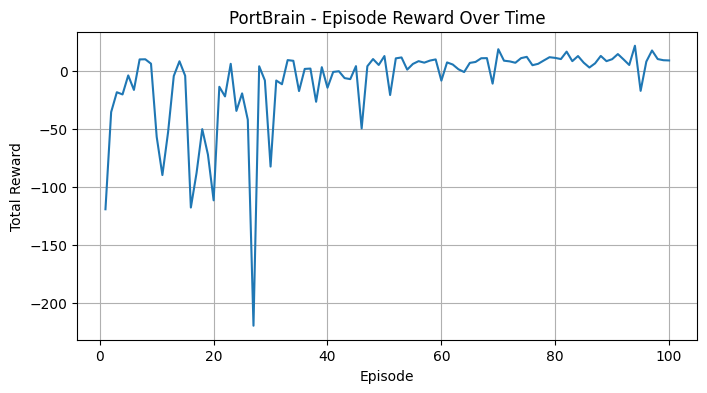

In [26]:
# ---------------------------------------------------------------
# Visualization 1 – Total Reward Over Episodes
# ---------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(history_df["episode"], history_df["total_reward"])
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PortBrain - Episode Reward Over Time")
plt.grid(True)
plt.show()

## 🧩 Block 12 – Visualization 2: Epsilon Decay

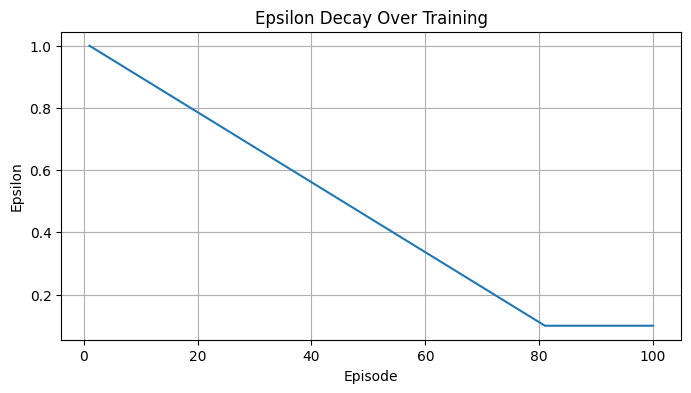

In [27]:
# ---------------------------------------------------------------
# Visualization 2 – Epsilon Decay Over Training
# ---------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(history_df["episode"], history_df["epsilon"])
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay Over Training")
plt.grid(True)
plt.show()

## 🧩 Block 13 – Visualization 3: Ships Handled vs Total Ships Seen

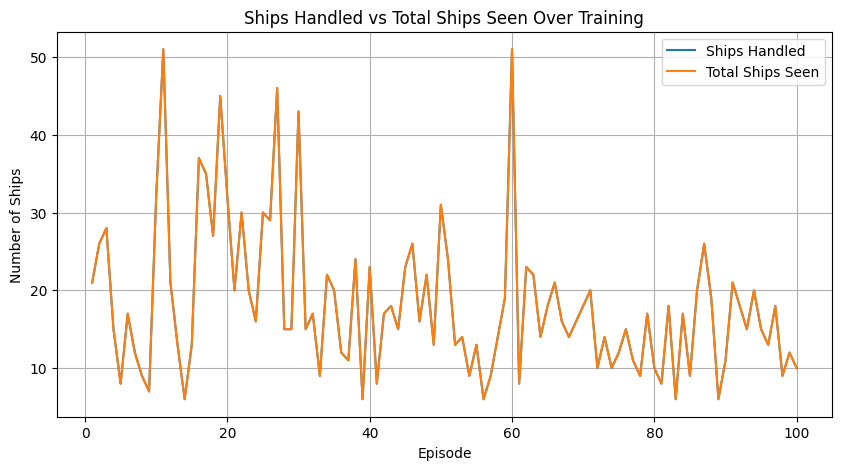

In [28]:
# ---------------------------------------------------------------
# Visualization 3 – Ships Handled vs Total Ships Seen
# ---------------------------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(history_df["episode"], history_df["ships_handled"], label="Ships Handled")
plt.plot(history_df["episode"], history_df["total_ships_seen"], label="Total Ships Seen")

plt.xlabel("Episode")
plt.ylabel("Number of Ships")
plt.title("Ships Handled vs Total Ships Seen Over Training")
plt.legend()
plt.grid(True)
plt.show()
